# Master Thesis - Mike Weltevrede

Currently, this notebook contains:
1. General processing functions and data exploration
2. Language analysis for the full text using `langid` (metadata has language in it!)
3. Text length analysis for ground truth texts using distribution fitting
4. Garbage classification using Kulp et al.'s rules

## Configuration

In [1]:
# Built-in libraries
import glob, json, math, os, random, re, string, sys, traceback 
import datetime as dt
from xml.etree import ElementTree
from pprint import pprint

# External libraries
import requests
import urllib3
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.snowball import DutchStemmer
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

# External libraries - extra
import langid
from langid.langid import LanguageIdentifier, model
from alto_tools import alto_tools

In [2]:
%matplotlib inline

data_path = "data"
ALTO_path = "Original ALTO files"
GT_path = "Reordered Ground-truth"

## Define processing functions

In [23]:
def find_root_name(doc):
    """Finds the document identifier AKA root name for a given ALTO XML or Ground Truth file

    Parameters
    ----------
    doc : str
        The file path of the text

    Returns
    -------
    root_name : str
        The document identifier
    doc_number : str
        The second part of the root_name
    """
    
    file_name_splitted = doc.split("\\")[-1].split("_")
    root_name = '_'.join(file_name_splitted[:3])
    doc_number = file_name_splitted[1]
    
    return root_name, doc_number

In [4]:
def find_document(doc, path = "data/Reordered Ground-truth", abs_path = True):
    """Finds the path to document according to the document identifier `doc` in the `path` folder

    Parameters
    ----------
    doc : str
        The document identifier
    path : str, optional
        The path where to search for the document, by default "data/Reordered Ground-truth"
    abs_path : bool, optional
        Whether to obtain the absolute path, by default True

    Returns
    -------
    gt_file_name : str
        The (absolute) path to the document
    """
    
    root_name = find_root_name(doc)
    
    gt_file_name = glob.glob(f"{path}/*{root_name}*")[0]
    
    if abs_path:
        return os.path.abspath(gt_file_name)
    
    return gt_file_name

In [5]:
def extract_text(path):
    """Extracts the text from the ALTO XML file

    Parameters
    ----------
    path : str
        Path to the ALTO XML file

    Returns
    -------
    words : list
        List of dictionaries containing the word, the word confidence WC, and the character
        confidence CC
    all_lines : list
        List of strings; the strings constitute one sentence
    entire_text : str
        String containing the entire text
    """
    
    _, xml, xmlns = alto_tools.alto_parse(os.path.abspath(path))
    
    words = []
    all_lines = []

    for lines in xml.iterfind('.//{%s}TextLine' % xmlns):

        full_line = ''

        for line in lines.findall('{%s}String' % xmlns):
            words.append({'word': line.attrib.get('CONTENT'),
                          'CC': line.attrib.get('CC'),
                          'WC': float(line.attrib.get('WC'))})
            full_line += line.attrib.get('CONTENT') + ' '

        all_lines.append(full_line)
        
    entire_text = ''.join(all_lines)
    
    # Replace multiple subsequent whitespaces by a single one
    re.sub(' +', ' ', entire_text)
    
    return words, all_lines, entire_text

In [95]:
def get_metadata(doc_number, which={'name', 'issue', 'date'}):
    """Gets metadata based on a document identifier

    Parameters
    ----------
    doc_number : str
        Document identifier for which to find the metadata

    Returns
    -------
    metadata : dict
        Dictionary containing the name of the source, issue of the document, and publication date

    Raises
    ------
    ValueError
        Raised when the URL cannot be accessed or when parsing from said URL fails
    """
    
    http = urllib3.PoolManager()
    url = (f"http://services.kb.nl/mdo/oai?verb=GetRecord&identifier=DDD:ddd:{doc_number}:"
           "mpeg21&metadataPrefix=didl")
    
    try:
        response = http.request('GET', url)
        
        soup = BeautifulSoup(response.data)
    
        # Find the newspaper name
        if 'name' in which:
            try:
                name = soup.find('dc:title')
                name = re.findall(r"<dc:title>(.*)<\/dc:title>", str(name))[0]
            except IndexError:
                name = None
        
        # Find the issue number
        if 'issue' in which:
            try:
                issue = soup.find('dcx:issuenumber')
                issue_string = re.findall(r"<dcx:issuenumber>(\d+)<\/dcx:issuenumber>",
                                         str(issue))[0]
                issue = int(issue_string)
            except IndexError:
                issue = None
        
        # Find the date
        if 'date' in which:
            try:
                date = soup.find('dc:date')
                date = re.findall(r"<dc:date>(\d{4}-\d{2}-\d{2})<\/dc:date>", str(date))[0]
                #date = dt.datetime.strptime(date, '%Y-%m-%d')
            except IndexError:
                date = None
            
        metadata = {'name': name, 'issue': issue, 'date': date}
        
        return metadata
        
    except:
        raise ValueError(f"Failed to get XML for '{doc_number}' from response (%s)"
                         % traceback.format_exc())


In [7]:
# Get (relative) paths of all ALTO XML files
alto_files = glob.glob(f"{data_path}/{ALTO_path}/*.xml")

## Data exploration
We do some simple data exploration to get familiar with the data. We consider the second file in our database: `alto_files[1]`.

In [52]:
# Extract the OCR version
words, all_lines, entire_text = extract_text(alto_files[1])

# Extract the corresponding ground truth
gt_file = find_document(alto_files[1])
words_gt, all_lines_gt, entire_text_gt = extract_text(os.path.abspath(gt_file))

Here we look at what the data looks like for the OCRed document:

In [53]:
# Test for OCR text
words[:5], all_lines[:5], entire_text[:100]

([{'word': 'Anno', 'CC': '9999', 'WC': 0.92},
  {'word': '1852.', 'CC': '99599', 'WC': 0.11},
  {'word': 'IM°.', 'CC': '9999', 'WC': 0.01},
  {'word': '599.', 'CC': '5299', 'WC': 0.31},
  {'word': 'DE', 'CC': '00', 'WC': 1.0}],
 ['Anno 1852. IM°. 599. ',
  'DE NEDERLANDER. ',
  'Vrijdag 11 Junij. ',
  'NIEUWE UTRECHTSCHE COURANT. ',
  '(ALGEMEEN STAATKUNDIG- NIEUWS- HANDELS- EN ADVERTENTIE-BLAD.) '],
 'Anno 1852. IM°. 599. DE NEDERLANDER. Vrijdag 11 Junij. NIEUWE UTRECHTSCHE COURANT. (ALGEMEEN STAATKU')

and for the corresponding ground truth document:

In [54]:
# Test for Ground Truth
words_gt[:5], all_lines_gt[:5], entire_text_gt[:100]

([{'word': 'Anno', 'CC': '9999', 'WC': 0.92},
  {'word': '1852.', 'CC': '99599', 'WC': 0.11},
  {'word': 'N°.', 'CC': '009', 'WC': 0.96},
  {'word': '599.', 'CC': '5299', 'WC': 0.31},
  {'word': 'DE', 'CC': '00', 'WC': 1.0}],
 ['Anno 1852. N°. 599. ',
  'DE NEDER-LANDER. ',
  'Vrijdag 11 Junij. ',
  'NIEUWE UTRECHTSCHE COURANT. ',
  '(ALGEMEEN STAATKUNDIG- NIEUWS- HANDELS- EN ADVERTENTIE-BLAD.) '],
 'Anno 1852. N°. 599. DE NEDER-LANDER. Vrijdag 11 Junij. NIEUWE UTRECHTSCHE COURANT. (ALGEMEEN STAATKU')

In particular, we consider the words side-by-side:

In [61]:
# Check Ground Truth versus XML words (notice different splitting due to spaces)
list(zip(words_gt, words))[:10]

[({'word': 'Anno', 'CC': '9999', 'WC': 0.92},
  {'word': 'Anno', 'CC': '9999', 'WC': 0.92}),
 ({'word': '1852.', 'CC': '99599', 'WC': 0.11},
  {'word': '1852.', 'CC': '99599', 'WC': 0.11}),
 ({'word': 'N°.', 'CC': '009', 'WC': 0.96},
  {'word': 'IM°.', 'CC': '9999', 'WC': 0.01}),
 ({'word': '599.', 'CC': '5299', 'WC': 0.31},
  {'word': '599.', 'CC': '5299', 'WC': 0.31}),
 ({'word': 'DE', 'CC': '00', 'WC': 1.0},
  {'word': 'DE', 'CC': '00', 'WC': 1.0}),
 ({'word': 'NEDER-LANDER.', 'CC': '0000000000000', 'WC': 0.97},
  {'word': 'NEDERLANDER.', 'CC': '000000000000', 'WC': 1.0}),
 ({'word': 'Vrijdag', 'CC': '9999919', 'WC': 0.96},
  {'word': 'Vrijdag', 'CC': '9999919', 'WC': 0.96}),
 ({'word': '11', 'CC': '99', 'WC': 0.01},
  {'word': '11', 'CC': '99', 'WC': 0.01}),
 ({'word': 'Junij.', 'CC': '939999', 'WC': 0.12},
  {'word': 'Junij.', 'CC': '939999', 'WC': 0.12}),
 ({'word': 'NIEUWE', 'CC': '991992', 'WC': 0.96},
  {'word': 'NIEUWE', 'CC': '991992', 'WC': 0.96})]

Notice that there is some different spacing, for instance €4,50 (one word) is written as '€ 4,50' (two words) in the ground truth data. As such, we cannot do element-wise comparisons (without cleaning the data first).

We are also interested in the distribution of word confidences. We namely notice that there are words that have a high confidence level but that are difficult to interpret. One of the reasons to start this internship was because the KB received feedback that the quality levels as delivered by ABBYY were not accurate at all. As such, we expect a lot of words to have high confidence.

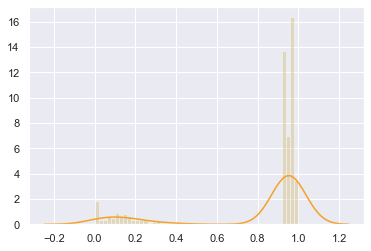

In [56]:
word_confidences = [word['WC'] for word in words if len(word['word']) > 3]
sns.distplot(word_confidences, color='y', kde_kws={"color": "#F5A027"})
plt.show()

We see that there is a clear bimodal distribution with almost no frequency away from the two modes. Moreover, the spread is not wide around the high-end mode (ranging from 0.92 to 1.0) and it is more spread out for the low-end mode (ranging from 0.0 to 0.48).

In [84]:
value_counts = {x: word_confidences.count(x) for x in word_confidences}
low_conf = sum([value for key, value in value_counts.items() if key <= 0.5])
high_conf = sum([value for key, value in value_counts.items() if key > 0.9])
total = sum(value_counts.values())

print(f"{low_conf} words ({round(100*low_conf/total, 2)}%) have confidence less than 0.5. "
      f"{high_conf} words ({round(100*high_conf/total, 2)}%) have confidence above 0.9. "
      f"So, {total - low_conf - high_conf} ({round(100*(total - low_conf - high_conf)/total, 2)}%) "
      "words are in between 0.5 and 0.9.")

177 words (18.81%) have confidence less than 0.5. 764 words (81.19%) have confidence above 0.9. So, 0 (0.0%) words are in between 0.5 and 0.9.


In [57]:
def conf_summary(words, min_confidence = 0.8, min_length = 2):
    print(f"Proportion of words with minimum confidence {min_confidence} and of any length: "
          f"{np.mean([conf > min_confidence for conf in [word['WC'] for word in words]])}")
    
    print(f"Proportion of words with minimum confidence {min_confidence} and length at least {min_length}: "
          f"{np.mean([conf > min_confidence for conf in [word['WC'] for word in words if len(word['word']) > min_length]])}")
    
conf_summary(words, 0.8, 3)

Proportion of words with minimum confidence 0.8 and of any length: 0.6915484268969772
Proportion of words with minimum confidence 0.8 and length at least 3: 0.8119022316684378


## Language test

Credits: https://github.com/saffsd/langid.py.

In [8]:
# Initialise LanguageIdentifier
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

Below, we conduct a simple test for the language of a document by plugging the entire text into the `langid.LanguageIdentifier` by `saffsd`. We document texts that were classified to be non-Dutch.

In [9]:
%%time
# Test language - 5 seconds for 30 files, 7 seconds for 50 files, 3 min and 20 seconds for 2000 files
language_test = {}

for alto_file in alto_files:
    _, _, text = extract_text(alto_file)
    root_name = find_root_name(alto_file)
    
    classification = identifier.classify(text)
    
    if classification[0] != 'nl':
        language_test[root_name] = classification
        
pprint(language_test)

{'DDD_010044654_001': ('fr', 1.0),
 'DDD_010045389_001': ('fr', 1.0),
 'DDD_010046915_001': ('fr', 1.0),
 'DDD_010047294_002': ('fr', 1.0),
 'DDD_010094339_002': ('fr', 1.0),
 'DDD_010094537_001': ('fr', 1.0),
 'DDD_010095235_002': ('fr', 1.0),
 'DDD_010196532_002': ('fr', 1.0),
 'DDD_010197719_002': ('fr', 1.0),
 'DDD_010722307_001': ('fr', 1.0),
 'DDD_010722378_001': ('fr', 1.0),
 'DDD_010912182_002': ('lb', 1.0),
 'DDD_010917543_001': ('lb', 1.0),
 'DDD_010917585_001': ('lb', 0.9999999999996649),
 'DDD_010965774_002': ('fr', 1.0),
 'DDD_011000582_001': ('en', 1.0),
 'DDD_011194960_001': ('lb', 1.0),
 'DDD_011211617_001': ('an', 1.0),
 'DDD_110598388_002': ('qu', 0.9833051195213641)}
Wall time: 3min 20s


Here, we test for the document numbers whether their ground truth version is also classified as the same language. If this is the case, it is likely that the document cannot necessarily be regarded as garbage. If they differ, then it is to be expected that OCR did not succeed.

In [10]:
language_test_GT = {}

for doc in language_test.keys():
    doc_GT = find_document(doc)
    _, _, text = extract_text(doc_GT)
    
    classification = identifier.classify(text)
    
    if classification[0] != language_test[doc][0]:
        language_test_GT[doc] = {"GT language": classification[0], "OCR language": language_test[doc][0]}

In [11]:
print(f"There are {len(language_test)} documents that were not classified as Dutch. Of these {len(language_test)} "
      f"documents, {len(language_test)-len(language_test_GT)} documents were classified as such in their ground "
      f"truth as well, meaning the following {len(language_test_GT)} documents are likely gibberish: \n")

pprint(language_test_GT)

There are 19 documents that were not classified as Dutch. Of these 19 documents, 14 documents were classified as such in their ground truth as well, meaning the following 5 documents are likely gibberish: 

{'DDD_010912182_002': {'GT language': 'nl', 'OCR language': 'lb'},
 'DDD_010917543_001': {'GT language': 'nl', 'OCR language': 'lb'},
 'DDD_010917585_001': {'GT language': 'nl', 'OCR language': 'lb'},
 'DDD_011194960_001': {'GT language': 'nl', 'OCR language': 'lb'},
 'DDD_110598388_002': {'GT language': 'nl', 'OCR language': 'qu'}}


Do note that this test does not necessarily show that these OCR texts are faulty. Below, we print out the full texts for all 19 documents that were classified as non-Dutch. We can see that the program did an okay job at identifying the language due to the documents being bilingual or actually being non-Dutch.

In [12]:
for doc, cls in language_test.items():
    my_file = find_document(doc, f"{data_path}/{ALTO_path}")
    my_gt_file = find_document(doc, f"{data_path}/{GT_path}")
    
    words, lines, text = extract_text(my_file)
    words_gt, lines_gt, text_gt = extract_text(my_gt_file)
    
    print(doc, cls[0], "\n--------------")
    print(text, "\n--------------")
    print(text_gt, "\n===========\n\n")

DDD_010044654_001 fr 
--------------
JOURNAL DE LA PROVINCE DE LIMBOURG. (N.° 5.) Samedi, 6 Janvier 182,1. PORTUGAL Lisbonne, le i 5 décembre. Les élections des députés se poursuivent avec acti vité dans cetle capitale et dons les provinces ; elles se font en tout conformément aux ordres qui ont été communiqués à ce sujet. Cependant , dans l'Alentejo on a découvert un parti qui voudrait réonir des cortèa à Lamego, mais afin d'étouffer dans 60n principe cette division , on a envoyé de cette capitale dans la sus dite province quelques régimtns d'infauterie et de cavalerie. Nos relations avec le cabinet de Madrid deviennent chaque jour plus fréquentes et plus amicales. Avant hier , nous avons vu arriver une estafette espagnole venant de Madrid , avec des dépêches pour notre gouvernement. Depuis quelques j >urs, un grand nom bre d'Espagnols affluent à Lisbonne. Le bruit court que des moavt-tnen» sérieux ont tu lieu ù Rio-laneîro aussitôt qu'on y a appris la nou velle des événemens du Portu

DDD_010045389_001 fr 
--------------
(N.* m.) JOURNAL DE LA PROVINCE DE LIMBOURG. Samedi, 13 Mai 182,0. ESPAGNE. Madrid, le 27 avril. Tous les décrets rendus par les cortès généraux et extraordinaires et par les cortès ordinaires , pour l e gouvernement et l'avancement des provinces d'outre mer , sont remis en vigueur pour que leurs habitans puissent dès-à-présent j >uir des avantages qui doivent leur résulter de ces dispositions. Par un décet du 2Ó avril , le roi a ordonné l'or ganisation dca milices nationales. Ce décret est suivi d'un autre sur le même objet : il établit un règlement provisoire pour la mi'ice nationale locale de la pé ninsule et îles adjacentes. Tout Espagnol , depuis l'âge de 18 ans jusqu'à celui de 60 accomplis , et en jouis sance de ses droits de citoyen , pourra faire partie de la nvlioe, toutefois qu'il s'obligera de s'habiller à *!" fra"* ** <le remplir les devoirs imposés par ie ré gletmat. Cet»* milice devra fournir les pos.es neces saires puur la tranquilli

DDD_010046915_001 fr 
--------------
Samedi , 29 Mars 1828. Prix d """" ' '''"^^TH^^^r^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^H ofl. pour six mois, 18 fl. POp OU r l'année !>_■' 1 'ournal rendu sans frais au domicile rln. .1. , „ chaque trimestre. On TaLïf-L^.*""» • P ol* toute P.ov^ nee et nou r les^ V 4 "" 5-° Ct ntS P° Ur tr°;s ™is > à tous les bureaux de poste. Le. letü eSc S "t n a,l^ 7"' N™"' W e 4 Maestricht h VT BS Urne •8«• * " pa(luels doivent être affranchis. ' Maestuchti chez les principaux libraires, et MM- les Souscripteurs dont I'alioiincineut expirera i U r,„ a sont unités à le renom .ler, alin de ne point t i„.„„" C,'m"ls. N.° 77. JOURNAL DE LA PROVINCE DE LIMBOURG. TURQUIE. Constantinople, le iZ février. Les persécutions contre les catholiques unitaires et 1 mesures sévères du gouvernement, contre lesquelles m£m les représentations des ulémas ont été infructueuse j toujours et n'ont point été modifiées depuis vn moisT, patriarche arménien devient de jour en iou 1 cherch

DDD_010047294_002 fr 
--------------
Il sera proposé à la Porte de fixer la délimitation con tinentale d'après une ligne qui serait tirée de l'entrée du golfe de Volo aux montagnes d'Olhry, en en suivant la chaîne jusqu'à la pointe occidentale d'Agrapha qui forme le point de jonction de ces montagnes avec la chaîne du Pinde. De ce point la ligne descendrait dans la vallée de l'Aspropotamos en passant au sud de Leontitos qui resterait à la Porte, puis elle se prolongerait jusqu'au golfe il'Ara bracie en traversant la chaîne de Macrinoro* de manière à laisser à la Grèce le ravin de ce nom qui touche à la plaine d'Arta. Tout le territoire situé au midi de celte ligne fera partie du nouvel état grec, ainsi que les isles voisines de la Morée, l'isle d'Eubée ou de Négrepont et les isles comprises sous la dénomin ition des Cyclades. Tribut. Délimitation du continent el des isles, Il sera proposé à la Porte au nom des trois puissances, que les Grecs lui paieront un tribut annuel de i,500,000 p

DDD_010094339_002 fr 
--------------
qu'au 10—22 septembre au soir, de 8992; décès 4608. —Pendant 32 jours, depuis l'apparition du cho léra, dans chacune des villes ci-après désignées, la proportion des décès sur toute la population est évaluée comme suit : ALemberg, 39 sur mille habit., soit 38/86 A Riga, 26 » » 25/87 AMittau, 22 » » 21/77 A Posen, 101/2 » » 10/57 APétersbourg, 101/2 » » 10/42 AKœnigsberg, 81/2 » » 8/60 AElbing, 8 » » 7/82 ADanlzig, 6 » » 6/90 AStettin, 4 » :> 4/97 A Berlin, 21/2 » » 2/41 JOURNAUX BELGES. (Extraits du Messager de Gand.) Du ,, 1"octobre. DES DEUX DERNIÈRES SÉANCES DE LA CHAMBRE. Nous ne savons si c'est pour singer la France jus qu'au bout, ou pour attirer un peu de monde à leurs tribunes abandonnées, que nos représentans se sont mis depuis quelques jours à faire duscandale, comme à Paris, et à s'entrejeter à la tête un paquet de grosses et solides vérités : ce qui n'a pas manqué d'augmenter prodigieusement le respect de la na tion pour ces estimables p

DDD_010094537_001 fr 
--------------
3 ,ne Année. Vendredi 20 Avril 1832. N° 95. JOURNAL DE LA HAYE. Ce journal paraît tocs les jours, le dimanche excepté, chez J. P. Beekman, Hz.; libraire éditeur à La Haye. Le prix de l'abonnement estdefl. 26 des Pays-Bai par an ou 7 fl- par trimestre pour La Haye, et 30 fl. par an ou 8 fl. par trimestre pour les autres villes du royaume. On souscrit également chez les principaux libraires, et à tous lés bureaux des postes On peut s'adresser à Paris pour les abonnemens et les annonces à V Office- Correspondance, chez MM. J. Bkessom eZBocRGoiN, rue Notre-Dame-dés-Victoires, n° 16. DU MOMENT PRÉSENT. La maladie de M. Périer est l'occasion d'innom brables conjectures politiques. Craintes, espéran ces, systèmes et appréhensions, tout est ranimé, et celte agitation des esprits explique pourquoi au cune hausse dans les fonds publics n'a signalé l'adoption du bill de réforme par la chambre des lords. Entre le triomphe de lord Grey et le danger du iuste-mili

DDD_010095235_002 fr 
--------------
s_£no.- qna s'est trouvée couronnée da succès la grande entreprise de la pacificalion du Portugal. Les opérations de notre armée ont eu lieu sur un très-grand développe ment de terrein , au cœur du Beira , dans le bassin du Mondégo , dans les districts deSerpa, Moura, Mourao , Juransegua , Elvas , Carapo-Mavor, Onguéla, Castello-de- Virle, Almeida, Bragance et Chavès, c'est-à-dire depuis les bouches de la Guadiana jusqu'à celle du Minho.» ESPAGNE ET PORTUGAL. Voici les réflexions que le départ de don Miguel et de don Carlos inspire au Mémorial des Pyrénées , qui malgré ses sympathies libérales a toujours présenté sans déguise ment sous leur véritable aspect les affaires de la Péninsule. « Le départ de don Miguel et celui de don Carlos se ro uve aujourd'hui confirmé. Ils vont quitter une terre qui leur a été funeste. La vie privée les attend; mais se résigneront-ils à y descendre? La question peut n'être pas douteuse pour le Portugais, elle l'est dav

En «utre de la dite inscription - tafttelte le Mairî les appelé d'après les lois citées ci -dessus, ils- au font encore à faire enregistrer au greffe du tribunal de première instance le titre en vertu duquel ils exercent leur profession , ou bien la pièce qui en tient lieu, le tout conformément à l'annonce faite \ar M- le Procu reur - Générai de la cour impériale. Et comme l'époque prescrite du _o novembre est lu ttante , le Maire, conformément au déstr de M. le Pré fet, exhorte les intéressés le plu» sérieusement possible et pour la dernière fois , à sas quitter de l'obligation qui leur est imposée , vu que la clôture dei regitres aura lieu définitivement, et sans délai ultérieur , le dit dernier jour de novembre. Amsterdam , le 21 novembre 1812. Le Maire , •> W . J. VAN 3RIENEN VAN DE GP.ÜOTE LINDT. ANNONCES JUDICIAI-LLS. CONVOCATION DE CRÉANCIERS. fS] Les créancier! de la faillite de PRETER VAN MËüiRS , ci-devant marchand de bas , ayant demeuré en cette ville, Barndesteeg, Nó. 1, so

DDD_010722378_001 fr 
--------------
NUMERO LXXXïV. NOUVELLES POLITIQUES, Publiées à L E Y D E, le ai. Oftobre 1800. . L'An fixième de la Liberté BaTA V e. De Livoerne, le 10. Septembre. E Brigniuin Anglais, la *'■"£" f*e , venant de Malte en 8. jours, annonce, que les deux >H J Fr -gates Françoifes , la Diane k la Jujlice de 40. Canons, Parties de Malte avec cinq r- "5té n Tra «sports richement chargés, r c^,.; 0Urrui vis par le Vr.iiTeau Anglais, "Sens £*»' qui s'eft emparé de tous ces 1M- Vp brô 8ate laJulUce feule exceptée. o 1 îl 0 , RENCE > i8- Septembre. t», Ce m 0 U î F, ont évacué, le n. h Ville .V/ W î«« &fonTerritoire, cet- f f - vir 'ont* « occupée le lendemainparunc s c *'"e» p " : L'Etat - Major Au '«nt; & e » a pris auflî-tôc le Commande e,tnemenf 0n y a un nouveau Gou- H lie U » V prov ifoire. La même chofe a t», Garnir" ko > où il y a en ce moment J'ojs '' lon Impériale. Voici les Piocla cette r" Gén éral Sommariva , publiées v!' A'„ B , à fMcques, 1. À C *«*A.M rî "" 

DDD_010917543_001 lb 
--------------
LEYDSE COURANT tl AAN D'A.ö'-; , ;to«^«.rr*\/«-.«vrf'-#'-*.ïfi;* ll (öAi v <o,e »;■s : ma:l' r' t: y ïiwccii <•«,,,»» ",;>jekkï N°. 26. j\z * ~ X öO/* LEYDEN den 28 February. Van tyd tot tyd be lemmerd 'gemorden örivj eene 'uitgebreidere "■ '<'! opgave; mede ■te deëleir Vari'.de Giften , het zy by • X'9[-SJvrv7.e van Collëaewlnfchryvsng' V óf '. anderfwts-, 'V * ';'•: fïï .-ter ondeTfteuning.onzë'r bngélukkige'Stad gedaan", " Wijlen \Vy dezèlYé.thanszbdar({g.laaten c volgen;.'als die ons: , «ot hiertoe dpörl de j ónderfcheidé publieke Dagbladen zyn: 'ïiekand. ge worden/:-"; '■}/". X^X^^Z^'XX^^'^^' s jj•.: .T> If V,VAN HOLLAND, öogenbüklyk \':,.:;-.V'/ p .\ ;,;.', ' i";.,'aia den• geleden ramp, om' iri dé" X-fX' X' '?,",■%r?,y X ■ X' ' dringende behoefte aérar-- % *■? ,' ';"-•'' 'ïifTif'onenlnwppners te voorzien,- eéne £"-> v'r.; ..'", 3 ...-:*.,'•.>.,j ; die men ;.'',*Vlv, §itv|s£ gewëastte zyn/j.vv^-lv^ij&i'f.^E;'] 3 *» 0 . 0 , 0 .r-^ o ,, i /.,°; 

DDD_010917585_001 lb 
--------------
LEYDSE COURANT. fsbefs A". iBd7- D-E;|'Nt ( B*fJ U'NfY:^ M^A/A'N.'DfA'G ITALIEN. ""Bk/ TT APELS den 1 Mey. * Dbor herigten* gelyktydig vjh • ' m*f ..'onderfchei4eri'{ftrëekéni4er !Mi44ellan4fche'Zee 't AöJ'■ ontfangen ,'wor4t 4e tyding bevestigd;'dat'4e En-; "/jjjp-'T ƒ gelfche Trouppes"/ welke on4er 4ënGenë'railFfii-. _+ ' A i; "ferihEgyptengeland zyn','a!4aar ainzienlykey'er-'. liezen géle4en hebben.--Wyverneenlenr;4atmén'no4igge." »or4eel4 heeft talryke verfterkingen te zen4en v ,'4ie.in alle haast uit Slciliën. tot hnlp 4ier EXpe4itie moeten afgaan.'-^f RUSLAND. APETERSBURG 4en-pMey.vHe4en ( 27Apriloude(lyl)' ; ftaat het Vs 4er Newa hier nog zo vast ƒ 4at mep genist over ; 4ié Rivier gaat."**a Dit is zön4er. vborbëel4;: want fe4ert het 'jaar 1718,', van welken tyd af.njéri gefegel4 4e'4ageh heeft opgeteekep4; waar op hetys los gegaan is il beeft hetzelve , nooit langer : geftaan 4an,töt den 26 April o; ft.' C 8-Mey ) ,"•: I te.weetea;ia 14e -Jaa

DDD_011000582_001 en 
--------------
BATAVIA. ZATURDAG, defi 2?ftcr. October, 1817. [No. 43. Ao. 1817.] Bataviasche Courant Bataviasche ZATUHDAG, den isften October, 1817. ZEE-TIJDINGEN. BATAVIA. Aangekomen. Cct. ip— Schip Jt'ianr.a Frederfia, P. de Haan, van Indramaiioe, den ijden Cct. 1P17. Jftneak. brik Coro mandel, D. Bra: : , van Saiem, den ziften ' Juni; I.' : ". Eng.' brik Ra/ph, Du Reuvrai], van -Mauri-, titis, den ï"T~k 'Aug. 1817. l..~ 20-—Eng. pü', C. Baijnes, van E. ■ i-d '«' Junij 1817. Amerik'. schip Chèfapeak, J. Groih, var. h den zffteh Junij f817. DiTp J : to Friendship, P. p é in Saiem, den iden Julij i%\f. ' : ai—MM La C.iKcerd". J. D. Christen, 5v, 'am, den liften Maart 1817, pasfagiers, C. S. Specht en H. 'v.v.i l r ,irrn... r -A:r.crik. schip TJentoo, N. Osgood, van Saiem, 1 fl |!7, Dito dito Union, /,/ ire, den .il?. Dito dito IVil m, Ruiter, van L&ridon, aften il 7. -fata fa la, Khe Tiau pict, van Saman ip, den zden Oet. 1817. ' •■ '22—Z. M, schip Amftèrdam, col

DDD_011194960_001 lb 
--------------
SURINAAMSCHE COURANT. GOUVERNEMENTS ADVERTENTIE BLAD. "!»■ tóW * '.: ï ! | ï,' ••> v•• *• ••••• •• • •••* -' '' ' V ' ■ •:< ■' ])é' atiOKDCUiCatfi pi'|)B deacr Courant, £is d«» ». i' "Dingsdagi ! Zaturfaga verscliijnt i ,1 v- «• by :Kiuariaahch'e vooruitbetaling ■;> per jaar f 20.— f r 'j é ',koorf t l^ t K v^>i " o.— i -St■'■• ■ JJifirf» f> , j jl.'ii J •••' m • foor «lk afaouderlyV nommer .. . » — 20 ,' ' - j : ' • V i' ': tWI - U ■ V ■ - l. , . DOADEftDAG ; 18 September , . j\«. ItS. >■'• .•; i, I>s Xe. -,• ■ -~ - *•* ■«A . • ' ' ■ ■ ft- ' " ] ■■■■ " A -•■vt.-... v -■- ~ ..v ■- • •■••vV'.:,-;-^ / D. prijs der Adverteuttëu i» : vr «a . ' Tojor eiken gewonen» règri . . . ; f >J rtt >& dai . (V??*•'■■ Ci aangeaonieju *•■' -7HT. : ■ ~ ■ , , . . .... , , . ;, ,'... -1 ■ *1 OFFICIEEL GEDEELTE. .Socretaiié. , ... . ... .t j ? i;r"OL ■ >■* den 17w- September ~1879._ •^?gr?yy: i m 1;; j • Afetand in 'pacht voor den lijd van één jaar Mij7i sjifi-I .. • •»;

For the documents that were inconsistently classified, we have the following results:

In [15]:
for doc, cls in language_test_GT.items():
    my_file = find_document(doc, f"{data_path}/{ALTO_path}")
    my_gt_file = find_document(doc, f"{data_path}/{GT_path}")
    
    words, lines, text = extract_text(my_file)
    words_gt, lines_gt, text_gt = extract_text(my_gt_file)
    
    print(doc, cls, "\n--------------")
    print(text, "\n--------------")
    print(text_gt, "\n===========\n\n")

DDD_010912182_002 {'GT language': 'nl', 'OCR language': 'lb'} 
--------------
, .'- Wordgcadverteerd," datuitkragtëvaneen Actevah'teerftébefault'eneèniweédéMandament,metde Claufule van JLdïëiê adVdlvas l' Curies dvariden' HoVé van Holland yin dato den 1.5 Juny; 177Ï» gèimpëtreérd by Atidd de Bye", Wed; van wylea Mr. : 'Piéter Jan Gefdlle ; ! ■ ; Regt óf Aftië të hebben tot tókere Sótn'vïn • Penningen v'óndtr/Heeren Bewiadhébbèren' van "de Amftérdam béruftendë',' én zynde hernogy 'J«ntl>reekèndeßeftabr vaa hét Vriehdea.iß'de'NaU^ 'j.te,'Bhiiy\a:ltitëftatvs'ovevle<zden voor 'dé tweede maal zya 'gedagvaard tégen Maandag den 2 Sep---' '.tembef.t77;!';',n'm te I: zien wyzéa het. verder pröfyt vaaden-voóffzi "Defaulte.;' ■'•■■ 77 ;.':.'■■;•' 7'- Vy; 7-. •--".■'.'-/,■ c'; d'dyyy.'y 1 - • Alle dré.gëène, rliëietste;preten("eeieiihëbbenbpden.Boedélvan G. SCHULTS y overléederi indemaand April i77ïtof Sürinanïea," ; f r b.innepdën tyd van certj.af'enzës Weétó^ '. leuren v*n woón?g"tig te-Sririnam

DDD_010917585_001 {'GT language': 'nl', 'OCR language': 'lb'} 
--------------
LEYDSE COURANT. fsbefs A". iBd7- D-E;|'Nt ( B*fJ U'NfY:^ M^A/A'N.'DfA'G ITALIEN. ""Bk/ TT APELS den 1 Mey. * Dbor herigten* gelyktydig vjh • ' m*f ..'onderfchei4eri'{ftrëekéni4er !Mi44ellan4fche'Zee 't AöJ'■ ontfangen ,'wor4t 4e tyding bevestigd;'dat'4e En-; "/jjjp-'T ƒ gelfche Trouppes"/ welke on4er 4ënGenë'railFfii-. _+ ' A i; "ferihEgyptengeland zyn','a!4aar ainzienlykey'er-'. liezen géle4en hebben.--Wyverneenlenr;4atmén'no4igge." »or4eel4 heeft talryke verfterkingen te zen4en v ,'4ie.in alle haast uit Slciliën. tot hnlp 4ier EXpe4itie moeten afgaan.'-^f RUSLAND. APETERSBURG 4en-pMey.vHe4en ( 27Apriloude(lyl)' ; ftaat het Vs 4er Newa hier nog zo vast ƒ 4at mep genist over ; 4ié Rivier gaat."**a Dit is zön4er. vborbëel4;: want fe4ert het 'jaar 1718,', van welken tyd af.njéri gefegel4 4e'4ageh heeft opgeteekep4; waar op hetys los gegaan is il beeft hetzelve , nooit langer : geftaan 4an,töt den 26 April o; ft

## Test for text lengths
We are interested in seeing whether the length of the text possibly gives an indication of the correctness of the OCR. This comes from the inspiration where

> PRACTISCHE CADEAUX VOOR IEDEREEN ZIJN LEDERWAREN VAN F.A. KUNST DOETINCHEM HAMBURGERSTR. 20. MEEST GESORTEERD MAGAZIJN IN OOSTELIJK GELDERLAND DAMESTASSCHEN MANICURES KAPDOOZEN REISNECESSAIRES PORTEMONNAIES MUZIEKTASSCHEN ACTETASSCHEN PORTEFEUILIES SIGARENKOKERS SIGARETTENKOKERS SIGARETTENDOOSJES REISROLLEN DASSEN- en BOORDENDOOZEN HOEDENDOOZEN VOETBALLEN VOETBALSCHOENEN FLUITEN ZAKMESSEN RUGZAKKEN HANDBESCHERMERS SPORTRIEMEN VELDFLESSCHEN KOFFERS MANDEN HORLOGEARMBANDEN STUURTASSCHEN ENZ. ENZ. Ziet onze prijzen!! ST. NICOLAASNUMMER VAN „DE GRAAFSCHAP-BODE". 

was OCRed to:

> E CADEAUX VOOR^— 1 lEDEREEN ZIJN 1 Z-ïeÊ onze prïfzjesaü ST. NICOLAASNUMMER VAN „DE ÜRAAFSCHAP-BODE"

where we note that the entire text from *LEDERWAREN* (first line) to *prijzen* (last line) was OCRed to just *1 Z-ïeÊ onze prïfzjesaü*. As such, the original text of 564 characters was reduced to only 100 characters. This can possibly have happened more often.

We first create a list of word lengths in the ground truth corpus.

In [16]:
lengths = []

for alto_file in alto_files: # All 2000 files!
    
    gt_file = find_document(alto_file, f"{data_path}/{GT_path}")
    words, _, _ = extract_text(gt_file)

    lengths.append(len(words))

# Show left tail
lengths.sort()
print(f"5 lowest lengths out of $N={len(lengths)}$: {lengths[:5]}")

5 lowest lengths out of $N=2000$: [23, 56, 110, 190, 229]


We see that the texts are generally of considerable length but that there are two texts that have quite a short length. A hard cut-off point is likely not usable. For a more intuitive insight, we give a distribution and box plot:

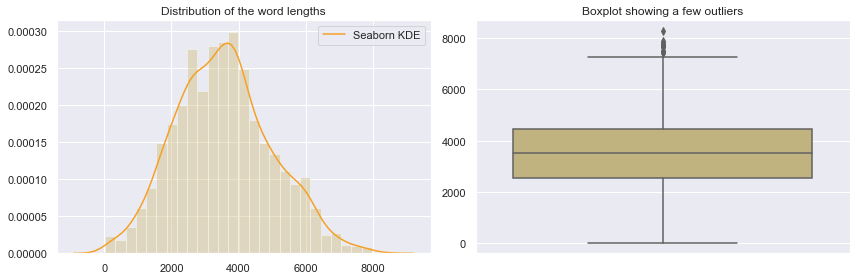

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(lengths, color='y', kde_kws={"color": "#F5A027"}, ax=ax1)
ax1.title.set_text("Distribution of the word lengths")

sns.boxplot(y=lengths, color='y', ax=ax2)
ax2.title.set_text("Boxplot showing a few outliers")

plt.tight_layout()
plt.show()

We see that the distribution is somewhat bell-shaped, though right-skewed. To model the word length (so that we may possibly utilise quantile methods, for example), we try to fit three distributions to this data: a normal distribution, a Gamma distribution, and a kernel density estimate.

In [18]:
def fit_distribution(data, distribution="norm"):
    """Fits the distribution to the data

    Parameters
    ----------
    data : list or array
        Data to fit the distribution to
    distribution : str, optional
        Distribution in scipy.stats to fit, by default "norm"

    Returns
    -------
    params : tuple
        Tuple containing the fitted parameters for the distribution specified
    """
    
    distr = getattr(stats, distribution)
    params = distr.fit(data)
    
    return params

In [19]:
distributions = {}
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)

# Fit a Normal
mu, std = fit_distribution(lengths, "norm")
distributions["norm"] = (mu, std)
p_norm = stats.norm.pdf(x, mu, std)

# Fit a Gamma
alpha, loc, beta = fit_distribution(lengths, "gamma")
distributions["gamma"] = (alpha, loc, beta)
p_gamma = stats.gamma.pdf(x, a=alpha, loc=loc, scale=beta)

We also try to fit a non-parametric kernel density estimate using `KernelDensity()` from Scikit-Learn. We select the Gaussian kernel and we select the bandwidth by 20-fold cross validation. The function `GridSearchCV()` from Scikit-Learn saves the best estimator and we can easily continue with this. I thank [jakevdp](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/) for inspiration for the code.

In [20]:
folds = 20 # 20-fold cross-validation
options = np.linspace(500, 1500, 100) # Set the possible options
lengths_grid = np.array(lengths).reshape(-1, 1)

# GridSearchCV
grid = GridSearchCV(KernelDensity(), {'bandwidth': options}, cv=folds)
grid.fit(lengths_grid)

optimal_index = np.argmin(grid.cv_results_['rank_test_score'])
optimal_bandwidth = grid.best_params_['bandwidth']
optimal_mean_score = grid.cv_results_['mean_test_score'][optimal_index]

print("Optimal bandwidth:", optimal_bandwidth)

Optimal bandwidth: 1095.9595959595958


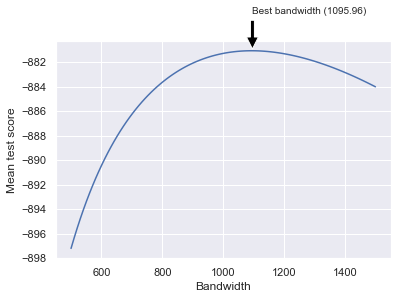

In [21]:
fig, ax = plt.subplots()
sns.lineplot(options, grid.cv_results_['mean_test_score'], ax=ax)
plt.xlabel("Bandwidth")
plt.ylabel("Mean test score")

ax.annotate(f'Best bandwidth ({round(optimal_bandwidth, 2)})', xy=(optimal_bandwidth, optimal_mean_score),
            xytext=(optimal_bandwidth, optimal_mean_score+3), arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

We can then plot all fitted/estimated distributions on top of the distribution plot of the lengths. The `Seaborn KDE` refers to the kernel density estimate made by the plotting package `Seaborn` in Python.

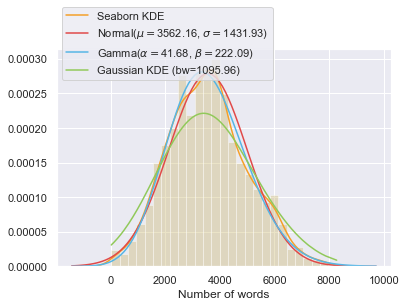

In [22]:
fig_dist, ax_dist = plt.subplots()

# Make plot of fitting distributions
sns.distplot(lengths, color='y', kde_kws={"color": "#F5A027","label": "Seaborn KDE"}, ax=ax_dist)
plt.xlabel("Number of words")

xmin, xmax = plt.xlim()
xlims = np.linspace(xmin, xmax, 100)

ax_dist.plot(xlims, p_norm, '#E14949', label = f"Normal($\mu=${round(mu, 2)}, $\sigma=${round(std, 2)})")
ax_dist.plot(xlims, p_gamma, '#55B5E5', label = f"Gamma($\\alpha=${round(alpha, 2)}, $\\beta=${round(beta, 2)})")
ax_dist.plot(lengths_grid, np.exp(grid.best_estimator_.score_samples(lengths_grid)),
             '#91C95A', label=f'Gaussian KDE (bw={round(optimal_bandwidth, 2)})')

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="upper left")
plt.show()

We can see that the Gaussian KDE actually does not fit the data well so we already exclude it on those grounds. To test whether the Normal and Gamma fits are accurate, we apply a Kolmogorov-Smirnov test.

In [23]:
def test_fits(data, distribution_params, alpha = 0.05):
    """Evaluates the fitted distributions on the data with a Kolmogorov-Smirnov test

    Parameters
    ----------
    data : list or array
        The data to test against
    distribution_params : dict
        Dictionary with scipy.stats distribution names as keys and fitted parameters as values
    alpha : float, optional
        Significance level to test at, by default 0.05
    """
    
    for distr, params in distribution_params.items():
        test = stats.kstest(data, distr, args=params)
        
        if test.pvalue < alpha:
            print(f"The lengths do NOT seem to come from a '{distr}' distribution "
                  f"(D={test.statistic}, p={test.pvalue})")
        else:
            print(f"The lengths DO seem to come from a '{distr}' distribution "
                  f"(D={test.statistic}, p={test.pvalue})")
            print(f"\tParameters: {params}")
            
test_fits(lengths, distributions)

The lengths do NOT seem to come from a 'norm' distribution (D=0.031301066247856224, p=0.03888407601397591)
The lengths DO seem to come from a 'gamma' distribution (D=0.015190903601338457, p=0.7452666211009464)
	Parameters: (41.68054448312341, -5694.685703264267, 222.09027710651858)


As such, we now assume that the word lengths follow a Gamma distribution with shape parameter $\alpha \approx 41.68$ and scale parameter $\beta \approx 222.09$.

## Garbage classification
Opmerking vanuit Mirjam: Stel dat de `langid` classifier een tekst als 'qu' classificeert, is dit dan omdat er veel garbage in staat of is het daadwerkelijk een goede tekst in de 'qu' taal?

### Kulp and Kontostathis, 2007
1. A string composed of more than 20 symbols is garbage.
2. A string that contains more special symbols than letters and digits is garbage.
3. A string containing at least 3 consecutive occurrences of the same symbol is garbage.
4. If the string is only composed of vowels and consonants and the number of consonants is greater than 8 times the number of vowels, or vice versa, the string is garbage.
5. When we delete both the first and the last symbol of a string and the rest contains at least two distinct punctuation symbols, then the string is garbage.
6. If a string starts and ends with lower-case letters and contains an upper-case letter it is garbage.
7. If the number of upper-case letters is larger than the number of lower-case letters and the string contains both types of letters it is garbage.
8. If a string contains 4 consecutive vowels or 5 consecutive consonants it is garbage.

### Wudtke et al., 2011
A SVM is trained with the following features:
1. The length $l$ of the input string,
2. The number $v$ of vowels and the number $c$ of consonants in the string, as well as the quotients $v/l$, $c/l$, $v/c$ (for $c \neq 0$),
3. The number of special (non-alphanumerical) symbols $s$ and the quotient $s/l$,
4. The number of digits $d$ and the quotient $d/l$,
5. The number of lowercase letters $low$, the number of uppercase letters $upp$, and the quotients $low/l$, $upp/l$.
6. For strings containing a sequence of at least three consecutive occurrences of the same symbol, we use the quotient of the length of the maximal sequence of identical letters divided by $l$. For other strings the feature receives value 0.
7. We calculate the number of all alpha-numerical symbols $l_{\alpha}$ occurring in the string, and the number $k$ of other symbols $s$. For $k > l_{\alpha}$ the value of Feature 7 is 1, for other strings the value is 0.
8. If the input string contains a subsequence of at least 6 directly consecutive consonants, Feature 8 received value 1, otherwise value 0.
9. We delete the first and last symbol of the input string. If the remaining infix contained two or more non-alphanumerical symbols, Feature 9 receives value 1, and otherwise value 0.
10. **(Bigram)** Form a frequency list $L_B$ of bigrams in historical documents. Define the "total naturalness" of bigrams in the string as $bigr = \frac{1}{n}\sum_{i=1}^n bf_i/c$, where $bf_i$ is the frequency of the $i^{th}$ bigram in $L_B$, $n$ denotes the number of bigrams in the string, and $c=10,000$ is a scaling constant. It was found that the average value for garbage strings is 5.3 and for non-garbage strings it is 17.4. (**If we want to apply this ourselves, we should verify the numbers with Dutch words.**)
11. **Most frequent symbol** Compute the number of occurrences $i$ of the most frequent symbol of the input string of length $l$. For $i \geq 3$, we used $i/l$ as a feature value. For $i <3 $, the value was set to 0. The feature is motivated by the observation that often garbage strings contain many occurrences of the same symbol.
12. **Non-alphabetical symbols** Let $l_1$ denote the number of occurrences of alphabetical symbols in the input string, let $l_2 = l - l1$ denote the number of occurrences of all other types of symbols. They used $l_2/l_1$ as a feature.
13. **Levenshtein distance** This feature tries to measure the plausibility of finding a simple (possibly vacuous) correction of the input string to a "plausible historical word". We say that an input string $V$ has a plausible correction (to a possible historical string) if there exists a possible historical word $U$ such that the Levenshtein distance between $V$ and $U$ does not exceed a given bound. In experiments they found that 80% of garbage words in their list do not have any plausible correction, while the corresponding value for non-garbage words is only 6.8%. They choose $b = 2$ as the maximal Levenshtein distance. Our Levenshtein feature has the value $l$ (length of input string $V$) if $V$ does not have a plausible correction. In the other case the value is $(\nu + p/2 + 1)/l$ where $\nu$ is the minimal Levenshtein distance between $V$ and a plausible correction $U$ and $p$ is the number of pattern applications needed to derive $U$ from a modern word $W$. (**If we want to apply this ourselves, we should verify the numbers with Dutch words.**)

In [43]:
def character_counter(word):
    """Discerns various character types in a word, for instance the number of lowercase letters and
    special symbols

    Parameters
    ----------
    word : str
        The word to discern

    Returns
    -------
    counts : dict
        Dictionary containing the number of vowels, consonants, uppercase letters, lowercase
        letters, digits, and special symbols

    Raises
    ------
    ValueError
        Raised when the word provided contains spaces, i.e. is not a single word, or if a character
        is seen as a letter but cannot be placed correctly
    """
    
    if ' ' in word:
        raise ValueError("Please give one word, not a sentence!")
    
    counts = {'vowels': 0, 'consonants': 0, 'upper': 0,
              'lower': 0, 'digits': 0, 'special': 0}
    
    for i in range(len(word)):
        char = word[i]
        
        if char >= 'A' and char <= 'z':
            # Char is a letter
            
            if char.lower() in {'a', 'e', 'i', 'o', 'u'}:
                # Char is a vowel
                counts['vowels'] += 1
            else:
                # Char is a consonant
                counts['consonants'] += 1
            
            if char >= 'A' and char <= 'Z':
                # Char is uppercase
                counts['upper'] += 1
            elif char >= 'a' and char <= 'z':
                # Char is lowercase
                counts['lower'] += 1
            else:
                if char in {'_', '[', ']', '^', '\\'}: # TODO: Probably a Python thing since these are reserved
                    counts['special'] += 1
                else:
                    print("Weird letter?", word, "char:", char)
                
        elif char >= '0' and char <= '9':
            # Char is a digit
            counts['digits'] += 1
            
        else:
            # Char is a special symbol
            counts['special'] += 1
    
    return counts

In [26]:
def consecutive_counter(word):
    """Counts the number of consecutive symbols
    
    Parameters
    ----------
    word : str
        The word to discern
    
    Returns
    -------
    counts : list
        List of tuples containing the symbol and its consecutive count
    max_count : int
        The maximum number of consecutive symbols in the word
    
    Raises
    ------
    ValueError
        Raised when the word provided contains spaces, i.e. is not a single word
    """   
    
    if len(word) == 1:
        return (((word, 1), ), 1)
    
    if ' ' in word:
        raise ValueError("Please give one word, not a sentence!")
    
    counts = []
    count = 1
    max_count = 1
    
    for char, char_next in zip(word, word[1:]):
        if char == char_next:
            count += 1
        else:
            if count > max_count:
                # Update maximum count
                max_count = count
            
            # Add to list
            counts.append((char, count))
            
            # Reset count
            count = 1

    counts.append((char_next, 1))
    
    return counts, max_count

In [27]:
def kulp_kontostathis(words):
    """Applies the garbage detection ruleset by Kulp and Kontostathis.

    Parameters
    ----------
    words : list
        List of dictionaries containing the words to test as value to a key called 'word'

    Returns
    -------
    garbage : list
        List of dictionaries stating the garbage words in the text and the rule under which they
        were classified as such.
    """
    
    garbage = []  # Structure: list of dictionaries

    for item in words:
        word = item['word']
        
        if len(word) == 1:
            # Skip this word (classify it as okay):
            continue
        
        # Classify the characters
        counts = character_counter(word)

        # Mike 1. If the number of special characters and numbers exceeds 1/3 of the string, it is garbage.
        if counts['special'] > math.ceil(len(word)/3):
            garbage.append({'word': word, 'rule': 'Mike'})
            continue
        
        # 1. A string composed of more than 20 symbols is garbage.
        if len(word) > 20:
            garbage.append({'word': word, 'rule': 1})
            continue

        # 2. A string that contains more special symbols than letters and digits is garbage.
        if counts['special'] > (len(word)-counts['special']):
            garbage.append({'word': word, 'rule': 2})
            continue

        # 3. A string containing at least 3 consecutive occurrences of the same symbol is garbage.
        if consecutive_counter(word)[1] >= 3:
            garbage.append({'word': word, 'rule': 3})
            continue

        # 4. If the string is only composed of vowels and consonants and the number of consonants
        # is greater than 8 times the number of vowels, or vice versa, the string is garbage.
        if counts['vowels'] + counts['consonants'] == len(word):
            if counts['vowels'] > 8*counts['consonants'] or counts['consonants'] > 8*counts['vowels']:
                if consecutive_counter(word)[1] >= 3:
                    garbage.append({'word': word, 'rule': 4})
                    continue

        # 5. When we delete both the first and the last symbol of a string and the rest contains at
        # least two distinct punctuation symbols, then the string is garbage.
        
        # TODO: Possibly exclude '-'?
        if character_counter(word[1:-1])['special'] >= 2:
            garbage.append({'word': word, 'rule': 5})
            continue

        # 6. If a string starts and ends with lower-case letters and contains an upper-case letter
        # it is garbage.
        if character_counter(word[0])['lower'] == character_counter(word[-1])['lower'] == 1:
            if counts['upper'] > 0:
                garbage.append({'word': word, 'rule': 6})
                continue

        # 7. If the number of upper-case letters is larger than the number of lower-case letters and
        # the string contains both types of letters it is garbage.
        if counts['upper'] > counts['lower'] > 0:
            garbage.append({'word': word, 'rule': 7})
            continue

        # 8. If a string contains 4 consecutive vowels or 5 consecutive consonants it is garbage.
        try:
            cons_counts, _ = consecutive_counter(word.lower())
            
            for c in cons_counts:
                char = c[0]

                if char >= 'A' and char <= 'z':
                    # Then char is a letter
                    if char in {'a', 'e', 'i', 'o', 'u'}:
                        # Then char is a vowel
                        if c[1] >= 4:
                            garbage.append({'word': word, 'rule': 8})
                            break

                    else:
                        # Then char is a consonant
                        if c[1] >= 5:
                            garbage.append({'word': word, 'rule': 8})
                            break
                            
        except TypeError:
            print("Type Error", word, cons_counts)
            
        return garbage


In [28]:
%%time
# Garbage test (6.14 seconds for 100 files, 27.8 seconds for 500 files, 1 min and 48 seconds for 2000 files)
# alto_files[4]: "&&.K'ibl)Cßl" is not seen as garbage, for example. => Introduce my own rule

garbage_test = {}

for alto_file in alto_files:
    words, _, _ = extract_text(alto_file)
    root_name = find_root_name(alto_file)
    
    KK = kulp_kontostathis(words)
    
    if len(KK) > 0:
        garbage_test[root_name] = {'garbage': KK, 'garbage_count': len(KK)}
        
pprint(garbage_test)

{'DDD_010004913_002': {'garbage': [{'rule': 6, 'word': 'porAert'}],
                       'garbage_count': 1},
 'DDD_010006127_002': {'garbage': [{'rule': 5, 'word': 'v__IVLNV»'}],
                       'garbage_count': 1},
 'DDD_010021477_001': {'garbage': [{'rule': 7, 'word': 'fIENDE'}],
                       'garbage_count': 1},
 'DDD_010024965_001': {'garbage': [{'rule': 'Mike', 'word': 'jfc-,-»---*»»-»'}],
                       'garbage_count': 1},
 'DDD_010027317_001': {'garbage': [{'rule': 3, 'word': 'AhnnnomonT'},
                                   {'rule': 'Mike', 'word': 'ï>w'}],
                       'garbage_count': 2},
 'DDD_010027797_001': {'garbage': [{'rule': 'Mike', 'word': 's«».'}],
                       'garbage_count': 1},
 'DDD_010032933_001': {'garbage': [{'rule': 5, 'word': 'Ariunn-tnn+sHn'},
                                   {'rule': 'Mike', 'word': '»-»'},
                                   {'rule': 'Mike', 'word': '->—•'},
                              

In [29]:
garbage_counts = [value['garbage_count'] for value in garbage_test.values()]
value_counts = {x: garbage_counts.count(x) for x in garbage_counts}
print(f"There are {sum(value_counts.values())} documents with at least one garbage word with the following value counts:")
pprint(value_counts)

There are 151 documents with at least one garbage word with the following value counts:
{1: 122, 2: 22, 3: 4, 4: 2, 5: 1}


## Dictionary look-up

In [47]:
def delpher_lookup(word):
    
    request = requests.get(f"https://www.delpher.nl/nl/api/lexicon?wordform={word}")
    wordforms = request.json()['wordforms_list'][0]['found_wordforms']
    
    return wordforms

In [48]:
words, all_lines, entire_text = extract_text(alto_files[1])

In [79]:
stemmer = DutchStemmer()

for item in words[:20]:
    word = item['word']
    print(word)
    
    # Assert that the word contains letters
    counts = character_counter(word)
    if counts['vowels'] + counts['consonants'] == 0:
        print("|--> is not a word")
        continue
    
    # Remove punctuation
    word = word.translate(str.maketrans('', '', string.punctuation)).lower()
    
    wordforms = delpher_lookup(word)
    
    if len(wordforms) > 0:
        print(f"|--> found with wordforms {wordforms}")
    else:
        print("|--> was NOT found. Trying to stem.")
        
        # Stemming word
        stemmed_word = stemmer.stem(word)
        
        if stemmed_word == word:
            print("|--> NO SUCCESS: Stemmed word is identical to original word.")
        else:
            wordforms = delpher_lookup(stemmed_word)

            if len(wordforms) > 0:
                print(f"|--> found with wordforms {wordforms}")
            else:
                print(f"|--> was still NOT found after stemming to {stemmed_word}.")

Anno
|--> was NOT found. Trying to stem.
|--> NO SUCCESS: Stemmed word is identical to original word.
1852.
|--> is not a word
IM°.
|--> was NOT found. Trying to stem.
|--> NO SUCCESS: Stemmed word is identical to original word.
599.
|--> is not a word
DE
|--> found with wordforms ['de', 'deden', 'déden', 'deê', 'deed', 'deeden', 'deed-je', 'deet', 'den', 'des', 'doe', 'doeje', 'doen', 'doende', 'doene', 'doet', 'duut', 'gedaan']
NEDERLANDER.
|--> found with wordforms ['nederlander', 'nederlanders']
Vrijdag
|--> found with wordforms ['vrijdag', 'vrijdagen', 'vrydag', 'vrydags']
11
|--> is not a word
Junij.
|--> was NOT found. Trying to stem.
|--> NO SUCCESS: Stemmed word is identical to original word.
NIEUWE
|--> found with wordforms ['nienweren', 'nieus', 'nieuw', 'nieuwe', 'nieuwen', 'nieuwere', 'nieuweren', 'nieuws', 'nieuwste', 'nieuwsten', 'niewen', 'nuuw']
UTRECHTSCHE
|--> found with wordforms ['uitersche', 'utrechts', 'utrechtsch', 'utrechtsche', 'utrechtse', 'utreghtse']
COURAN

## Significant words
The purpose is to find the most significant words of a text (i.e. the words that people would use to search for the text) and to see how well these have been predicted/recognized.

## Similar documents
Here, we develop a method to detect which documents can reasonably be seen as similar. First we get the metadata, amongst others to receive the document date. Possibly, it is also interesting to investigate if we can obtain the font.

In [149]:
%%time
# 1h 11min for the full loading from website

metadata_path = f"{data_path}/metadata.json"
parse_dates = True

if os.path.isfile(metadata_path):
    date_empty_count = 0
    
    with open(metadata_path, 'r') as f:
        dict_metadata = json.load(f)
    
    if parse_dates:
        for key, value in dict_metadata.items():
            if value['date'] is not None:
                dict_metadata[key]['date'] = dt.datetime.strptime(value['date'], '%Y-%m-%d')
            else:
                date_empty_count += 1
        
        print(f"{round(100*date_empty_count/len(dict_metadata), 2)}% of dates were None and were hence not parsed.")
else:
    # This will take long!
    dict_metadata = {}
    
    for alto_file in tqdm(alto_files):
        root_name, doc_number = find_root_name(alto_file)
        dict_metadata[root_name] = get_metadata(doc_number)
    
    # Save locally for easy import - 170KB
    with open(f"{data_path}/metadata.json", 'w') as f:
        json.dump(dict_metadata, f)

51.25% of dates were None and were hence not parsed.
Wall time: 20.9 ms


In [150]:
df_metadata = pd.DataFrame.from_dict(dict_metadata, orient="index")
df_metadata.head()

,name,issue,date
DDD_000010534_002,Algemeen Handelsblad,10764.0,1866-07-03
DDD_000012234_001,De Nederlander : nieuwe Utrechtsche courant : ...,599.0,1852-06-11
DDD_000013135_001,De Nederlander : nieuwe Utrechtsche courant : ...,374.0,1851-09-16
DDD_000013216_002,De Nederlander : nieuwe Utrechtsche courant : ...,455.0,1851-12-19
DDD_000014678_001,Provinciale Overĳsselsche en Zwolsche courant ...,88.0,1862-07-23


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


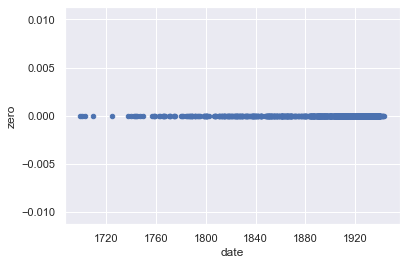

In [151]:
df_metadata['zero'] = 0
df_metadata.plot('date', 'zero', kind='scatter')
plt.show()

We start to test clustering only on a date level.

In [152]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score#, silhouette_samples
# To choose number of clusters (without ground truth data):
# - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
# - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score
# - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score

In [161]:
ss = {}
max_k = 50
max_ss = -1
X = df_metadata.date.values.reshape(-1, 1)

for k in range(2, max_k+1):
    KM = KMeans(k, random_state=0).fit(X)
    ss[k] = silhouette_score(X, KM.labels_)
    
    if max_ss < ss[k]:
        optimal_k = k
        max_ss = ss[k]
    
#optimal_k = max(ss, key=ss.get) # By Ockham's razor, take the *lowest* k with the highest score
optimal_k, max_ss

(2, 0.8841591992436734)

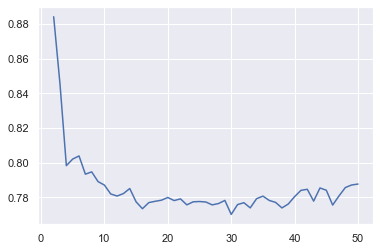

In [162]:
sns.lineplot(range(2, max_k+1), list(ss.values()))

In [125]:
KM = KMeans(optimal_k, random_state=0).fit(X)

In [126]:
df_metadata['cluster'] = KM.labels_

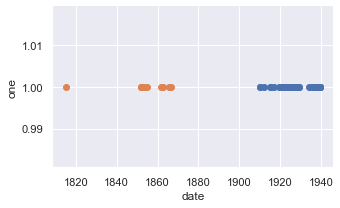

In [130]:
fg = sns.FacetGrid(data=df_metadata, hue='cluster', aspect=1.61)
fg.map(plt.scatter, 'date', 'zero')
plt.show()

# Miscellaneous

In [ ]:
# TODO: Do we train this for all data or do we split it up per time period?
def garbage_finder(words): # Wudtke et al
    
    # Create features
    dic = {'word': [],
           'string_length': [], # F1
           'vowels': [], # F2
           'consonants': [], # F2
           'vowels_over_length': [], # F2
           'consonants_over_length': [], # F2
           'vowels_over_consonants': [], # F2
           'nonalphanumeric': [], # F3
           'nonalphanumeric_over_length': [], # F3
           'digits': [], # F4
           'digits_over_length': [], # F4
           'lowercase': [], # F5
           'uppercase': [], # F5
           'lowercase_length': [], # F5
           'uppercase_length': [], # F5
           'consecutive_symbols_over_length': [], # F6 -> See if I get it well enough
           'others_versus_alphanumeric': [], # F7
           'consecutive_consonants': [], # F8
           'nonalphanumeric_overload': [], # F9
           'bigram': [], # Bigrams
           'most_frequent_symbol_ratio': [], # Most frequent symbol over length
           'nonalphabetical_symbols_ratio': [], # Other symbols over Number of alphabetical symbols 
           'levenshtein': [] # Levenshtein distance
          }
    
    for item in words:
        word = item['word']
        
        dic['word'].append(word)
        dic['string_length'].append(len(word))
        
        # Feature 2
        # TODO: Write code to count vowels, consonants, uppercase, lowercase, etc.
        
        dic['vowels'].append()
        dic['consonants'].append()
        dic['consonants'].append()